In [1]:
#bidirectional lstm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, GRU, Bidirectional, LSTM
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix



In [3]:

class dataprep:

    def load_data(self):
        #loading the relevant csv files:
        student_info = pd.read_csv("E:\\DL project\\anonymisedData\\studentInfo.csv")
        columns_to_remove = ['gender', 'region', 'highest_education', 'imd_band','age_band','studied_credits' ]
        student_info = student_info.drop(columns = columns_to_remove)
        #student_info.head()

        #loading assessment scores
        student_assessment = pd.read_csv("E:\\DL project\\anonymisedData\\studentAssessment.csv")
        student_assessment = student_assessment.drop(columns = 'is_banked')
        #student_assessment.head()

        #loading assessments
        assessments = pd.read_csv("E:\\DL project\\anonymisedData\\assessments.csv")
        #assessment.head()

        return student_assessment, student_info, assessments


    #produces course-wise dataframes for each student's evaluations
    def sort_data(self, course):
        student_assessment, student_info, assessments = self.load_data()

        df = pd.DataFrame()
        df['id_student'] = student_info['id_student']
        df['disability'] = student_info['disability']

        filtered_course_result = student_info[student_info['code_module']== course]
        results = filtered_course_result['final_result']
        df['final_results'] = results

        filtered_assessments = assessments[assessments['code_module'] == course]
        list_assessments = filtered_assessments['id_assessment'].unique().tolist()
        #print(list_assessments)

        filtered_assessments = assessments[assessments['code_module'] == course]
        list_presentations = filtered_assessments['code_presentation'].unique().tolist()
        #print(list_presentations)

        #drop everything but this course
        filtered_st_assessments = student_assessment[student_assessment['id_assessment'].isin(list_assessments)]

        pivoted_st_assessments = filtered_st_assessments.pivot(index='id_student', columns='id_assessment', values='score').reset_index()
        pivoted_st_assessments.fillna(0, inplace=True)

        pivoted_st_assessments.head(200)

        df = pd.merge(df, pivoted_st_assessments, on='id_student', how='left')
        df.dropna(subset=['final_results'], inplace=True)

        df.fillna(0, inplace = True)

        #print(df.head())

        return df, list_assessments, list_presentations
    
    
    def update_assessment_list(self, df):
        column_names = df.columns.tolist()
        assessment_cols =  column_names[3:]

        return assessment_cols


    #as the name implies, it calculates the relevant averages for each course and puts them in a dataframe for the final score and score classes
    #def calculate_totals(self, df):
    
    def calculate_scores(self, course ):
        df, list_assess, list_pres = self.sort_data(course)
        assess_cols= self.update_assessment_list(df)

        #calculate average scores for each student

        df['average_score'] = df[assess_cols].mean(axis=1)
        final_results_scores = {"Distinction":2,"Pass": 1, "Fail": -1, "Withdrawn": 0}
        df['final_results'] = df['final_results'].map(final_results_scores)
        disability_status = {"Y":1 ,"N":0}
        df['disability'] = df['disability'].map(disability_status)

        df['total_score'] = (0.5 * df['final_results']) + (0.3 * df['disability']) + (0.2 * df['average_score'])

        #diving data into classes
        new_score_ranges = [(-1, 2), (3, 7), (8, 12), (13, 17), (18, 21)]  
        class_labels = [1, 2, 3, 4, 5]
        df['score_class'] = pd.cut(df['total_score'], bins=[range[0] for range in new_score_ranges] + [max(new_score_ranges[-1])], labels= class_labels)

        #dropping irrelevant columns
        first_three_cols = df.iloc[:, :3]

        # Get the last three columns
        last_three_cols = df.iloc[:, -3:]

        # Create a new DataFrame with the selected columns
        new_df = pd.concat([first_three_cols, last_three_cols], axis=1)

        return new_df

        #print(new_df)


    def create_final_dataset(self):
        #loading courses
        courses = pd.read_csv("E:\\DL project\\anonymisedData\\courses.csv")
        courses = courses.drop(columns = 'module_presentation_length')

        unique_course_modules = courses['code_module'].unique()

        final_df = pd.DataFrame()


        for course_module in unique_course_modules:
            final_df = pd.concat([final_df, self.calculate_scores(course_module)], ignore_index=True)

        #print(final_df)

        return final_df
    
    
    
    def visualize_data(self):
        df = self.create_final_dataset()

        class_labels = [1,2,3,4,5]

        #class wise visualization
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='score_class', y='average_score', data=df, order=class_labels)
        plt.title('Distribution of Average Scores in Each Class')
        plt.xlabel('Score Class')
        plt.ylabel('Average Score')
        plt.show()

        #histogram
        plt.figure(figsize=(10, 6))
        plt.hist(df['total_score'], bins=30, color='skyblue', edgecolor='black')
        plt.title('Distribution of Final Scores')
        plt.xlabel('Final Score')
        plt.ylabel('Frequency')
        plt.show()

        #numeric class distribution
        plt.figure(figsize=(10, 6))
        plt.hist(df['total_score'], bins=5, color='lightcoral', edgecolor='black')
        plt.title('Distribution of Final Scores (Numeric Classes)')
        plt.xlabel('Numeric Class')
        plt.ylabel('Frequency')
        plt.show()


In [4]:
data_p = dataprep()
data = data_p.create_final_dataset()
#data_p.visualize_data()


In [5]:
def prepare_sequences(d, time_steps):
    sequences = []
    labels = []

    for i in range(len(d) - time_steps):
        seq = data.iloc[i:i+time_steps][['disability', 'final_results', 'average_score', 'total_score']].values
        label = data.iloc[i+time_steps]['score_class']
        sequences.append(seq)
        labels.append(label)

    return np.array(sequences), np.array(labels)

# Set the correct column names for the labels
time_steps = 7
sequences, labels = prepare_sequences(data, time_steps)

# Split sequences and labels into training and testing sets
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(sequences, labels, test_size=0.2, random_state=42)


In [6]:
#one-hot encoding for the labels
y_train_seq = to_categorical(y_train_seq, num_classes=5)
y_test_seq = to_categorical(y_test_seq, num_classes=5)

# Check the shape of y_train_one_hot
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of y_train_seq:", y_test_seq.shape)

Shape of y_train_seq: (26068, 5)
Shape of y_train_seq: (6518, 5)


In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50)))
#model.add(Dropout(0.2))
model.add(Dense(units=5, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32)


Epoch 1/20
815/815 [==============================] - 74s 35ms/step - loss: 0.7730 - accuracy: 0.5549
Epoch 2/20
815/815 [==============================] - 22s 27ms/step - loss: 0.7455 - accuracy: 0.5639
Epoch 3/20
815/815 [==============================] - 27s 33ms/step - loss: 0.7385 - accuracy: 0.5714
Epoch 4/20
815/815 [==============================] - 24s 29ms/step - loss: 0.7380 - accuracy: 0.5686
Epoch 5/20
815/815 [==============================] - 19s 23ms/step - loss: 0.7350 - accuracy: 0.5724
Epoch 6/20
815/815 [==============================] - 25s 31ms/step - loss: 0.7339 - accuracy: 0.5742
Epoch 7/20
815/815 [==============================] - 24s 29ms/step - loss: 0.7332 - accuracy: 0.5746
Epoch 8/20
815/815 [==============================] - 22s 27ms/step - loss: 0.7315 - accuracy: 0.5769
Epoch 9/20
815/815 [==============================] - 21s 25ms/step - loss: 0.7311 - accuracy: 0.5739
Epoch 10/20
815/815 [==============================] - 21s 26ms/step - loss: 0.730

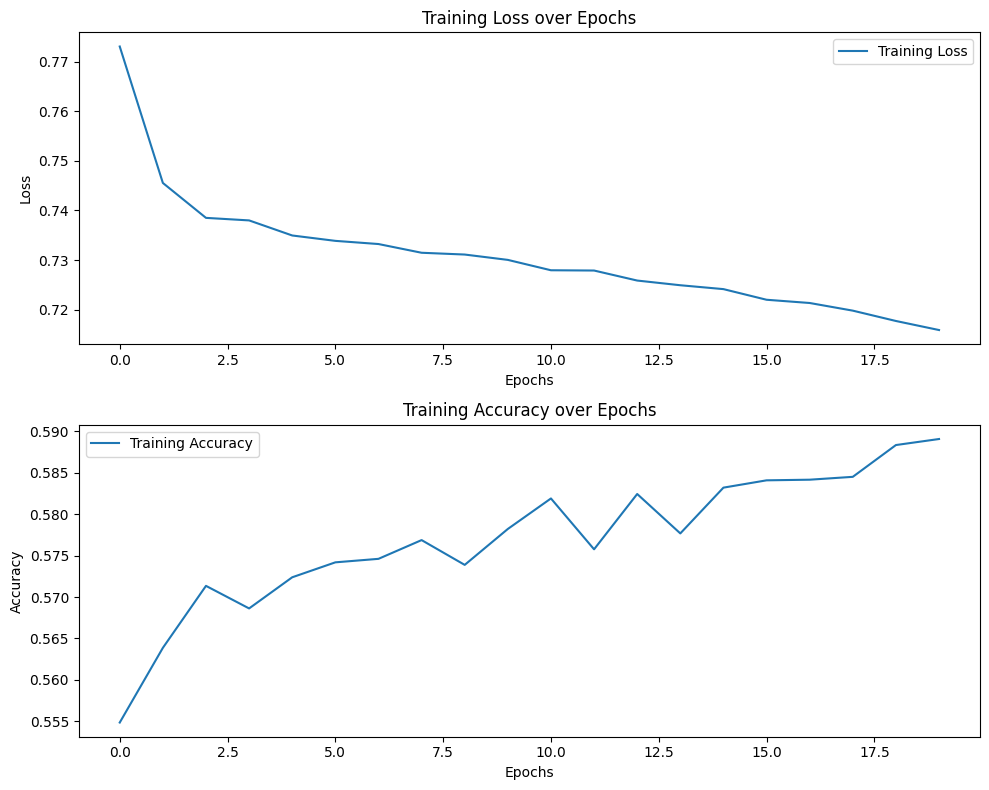

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# Plot training loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training Loss over Epochs')

# Plot training accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training Accuracy over Epochs')

plt.tight_layout()
plt.show()

In [10]:
y_pred = model.predict(X_test_seq)
print("Shape of y_pred:", y_pred.shape)


204/204 [==============================] - 7s 9ms/step
Shape of y_pred: (6518, 5)


Accuracy: 0.5674
Precision: 0.5552
Recall: 0.5674
F1 Score: 0.5563


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


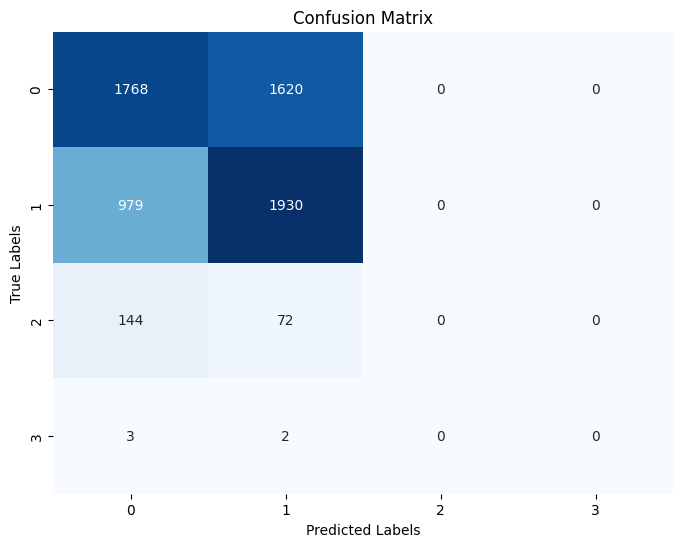

In [12]:
#evaluating the model

y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes = to_categorical(y_pred_classes, num_classes=5)


# Convert the true labels to a similar format
y_test_classes = y_test_seq.astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Display the confusion matrix
y_test_indices = np.argmax(y_test_classes, axis=1)
y_pred_indices = np.argmax(y_pred_classes, axis=1)

conf_matrix = confusion_matrix(y_test_indices, y_pred_indices)
plt.figure(figsize= (8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()